In [ ]:
try:    
    import alpaca_trade_api
except:
    !pip install PyYAML==5.4.1 --ignore-installed
    !pip install alpaca_trade_api
try:
    import stldecompose
except:
    !pip install scipy==1.2.1
    !pip install statsmodels==0.10.2
    !pip install stldecompose==0.0.5
!pip install xgboost

In [1]:
import importlib
from stldecompose import decompose
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from xgboost import XGBRegressor
from xgboost import plot_importance
import pandas as pd
from StlSlope import StlSlope
import ApiClient as ac
importlib.reload(ac)

C:\Users\lukas\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


<module 'ApiClient' from 'e:\\Education\\UW\\EE P 596 A\\Assignment_05\\ApiClient.py'>

In [2]:
["FB", "MSFT","AMZN","AAPL","NFLX","AMD","GOOG"]
ticker = "GOOG"
client = ac.ApiClient('PKT5HIHQ45ISLOSN5GI8','KxFFHReyWaveCZo4Lbwbr6m9YEmaGVvK3rqK3eLr')
df= client.get_closing_price(ticker,255)
df.index=pd.to_datetime(df.index,utc=True)

reading from file
e:\Education\UW\EE P 596 A\Assignment_05\data\GOOG.csv


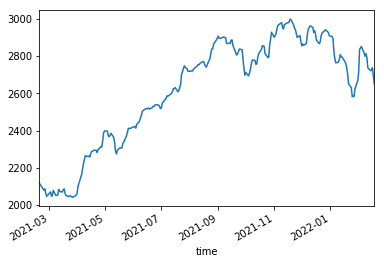

In [3]:
from MovingAverageCalculator import MovingAverageCalculator as MA
ema_x = MA(df).EMA(period=3, column='close')
ema_x.ema_3.plot()

In [4]:
#makring lowest point and hight point as buy and sell sign
ema_y = [0]
for i in range (1,(ema_x).shape[0]):
    #sell
    if ema_x.ema_3[i] == np.max(ema_x.ema_3[i-1:i+2]):
        ema_y.append(-1)
    #buy
    elif ema_x.ema_3[i] == np.min(ema_x.ema_3[i-1:i+2]):
        ema_y.append(1)
    else:
        ema_y.append(0)

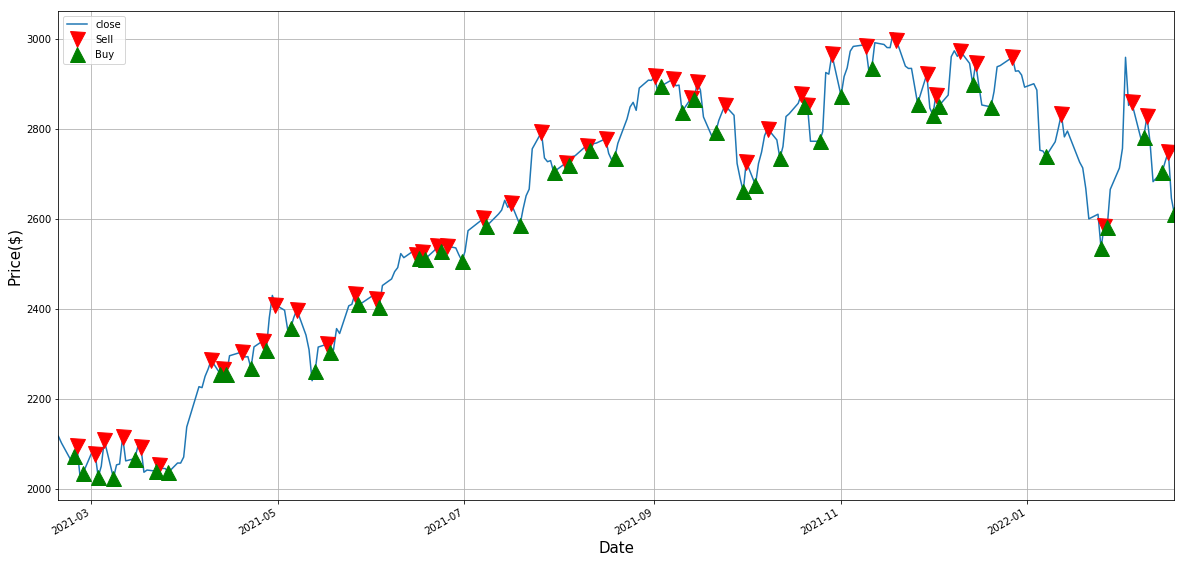

In [5]:
# plot all possible buy and sell points
ema_x[['close']].plot(figsize=(20, 10))
#plot sell
plt.plot(ema_x.loc[np.array(ema_y) == -1.0].index, 
                 ema_x.close.loc[np.array(ema_y)  == -1.0],'v', 
                 markersize=15, color='r', label="Sell")

#plot buy
plt.plot(ema_x.loc[np.array(ema_y)  == 1.0].index, 
            ema_x.close.loc[np.array(ema_y)  == 1.0],'^', 
            markersize=15, color='g', label="Buy") 
plt.ylabel('Price($)', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.legend()
plt.grid()
plt.show()

In [11]:
# split train and test for backtesting
ema_y=np.array(ema_y)
train_x,test_x,train_y,test_y = train_test_split(ema_x[['open','high','low','close']],ema_y,train_size = 7/12,  shuffle=False)
checking_profit = test_x.close.values

C:\Users\lukas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
#scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_x[['open','high','low','close']] = scaler.fit_transform(train_x[['open','high','low','close']])
test_x[['open','high','low','close']] = scaler.fit_transform(test_x[['open','high','low','close']])

In [8]:
# Train and prediction
from sklearn.neural_network import MLPClassifier
emalf = MLPClassifier(max_iter =5000,solver='lbfgs',
                      alpha=1e-5,hidden_layer_sizes=(200, 100), random_state=2)
emalf.fit(train_x, train_y)
hold = 0
predict=[]
for i in emalf.predict(test_x):
  #sell
  if i ==-1 and hold ==1:
    predict.append(-1)
    hold = 0
  #buy
  elif i == 1 and hold ==0:
    predict.append(1)
    hold = 1
  #hold
  else:
    predict.append(0)
predict=np.array(predict)
predict

array([ 0,  1, -1,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  1,  0,
       -1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1,  0,  1,  0,  0,  0,
        0,  0, -1,  0,  1, -1,  1,  0,  0,  0,  0,  0, -1,  0,  1,  0,  0,
        0,  0,  0, -1,  0,  0,  1, -1,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0, -1,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  1,  0,  0,  0])

In [12]:
# profit checking
h=100000
print('Principal: $',h)
sell = checking_profit[predict == -1.0]
buy = checking_profit[predict == 1.0]

for i in range(sell.shape[0]):
  h=h/buy[i]*sell[i]
print("get: $",h-100000,"\nThat's ",h/100000,"%")

Principal: $ 100000
get: $ 3886.2287051387248 
That's  1.0388622870513873 %


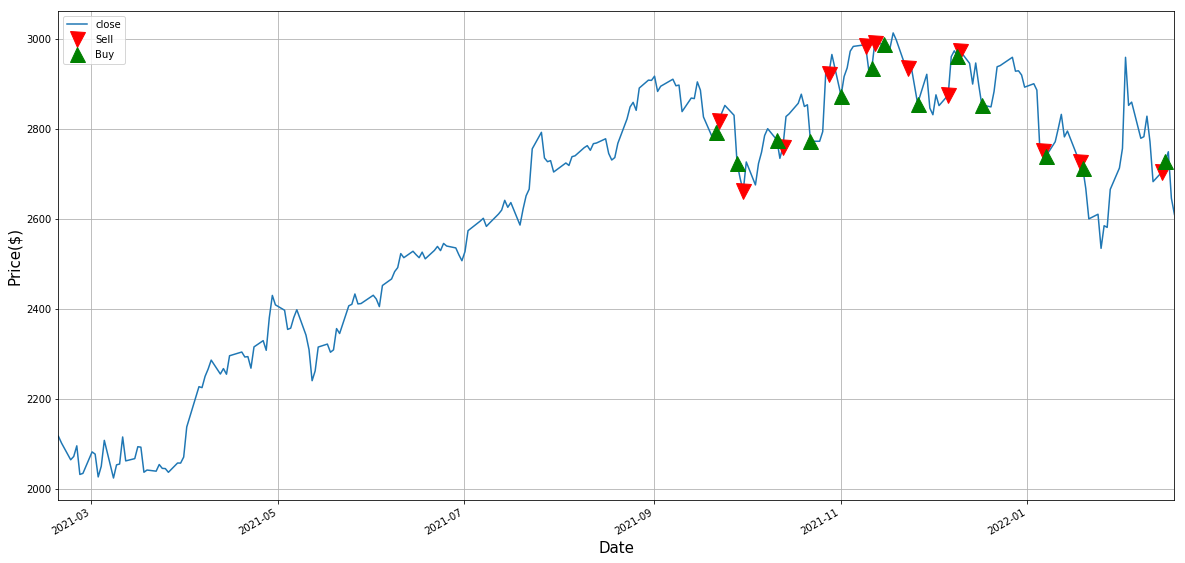

In [13]:

all = np.hstack((np.zeros_like(train_y.flatten()),predict))
ema_x[['close']].plot(figsize=(20, 10))

#plot sell
plt.plot(ema_x.loc[all == -1.0].index, 
                 ema_x.close.loc[all== -1.0],'v', 
                 markersize=15, color='r', label="Sell")

#plot buy
plt.plot(ema_x.loc[all  == 1.0].index, 
            ema_x.close.loc[all  == 1.0],'^', 
            markersize=15, color='g', label="Buy") 
plt.ylabel('Price($)', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.legend()
plt.grid()
plt.show()